### Can models trained on Reddit understand Voat?

In [26]:
# Loading and Preparing the Data

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

nlp = pd.read_parquet(
    r"D:\Varun Kumar\Proejekt\Data\processed\nlp_sample_full.parquet"
)

# Binary toxicity label
nlp["toxic"] = (nlp["toxicity"] > 0.2).astype(int)

# Features: lexicon + transformer sentiment
X = nlp[["sentiment_vader","sentiment_bert"]]
y = nlp["toxic"]

reddit = nlp[nlp["platform"] == "reddit"]
voat   = nlp[nlp["platform"] == "voat"]


In [27]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    reddit[["sentiment_vader","sentiment_bert"]],
    reddit["toxic"],
    test_size=0.3,
    random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("Reddit → Reddit")
print("AUC:", roc_auc_score(y_test, probs))
print("F1:", f1_score(y_test, preds))


Reddit → Reddit
AUC: 0.6603776930186833
F1: 0.0


In [28]:
X_train = reddit[["sentiment_vader","sentiment_bert"]]
y_train = reddit["toxic"]

X_test  = voat[["sentiment_vader","sentiment_bert"]]
y_test  = voat["toxic"]

model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("Reddit → Voat")
print("AUC:", roc_auc_score(y_test, probs))
print("F1:", f1_score(y_test, preds))


Reddit → Voat
AUC: 0.6846544036719397
F1: 0.0


In [29]:
# Train on Voat, test on Reddit
model.fit(voat[["sentiment_vader","sentiment_bert"]], voat["toxic"])

preds = model.predict(reddit[["sentiment_vader","sentiment_bert"]])
probs = model.predict_proba(reddit[["sentiment_vader","sentiment_bert"]])[:,1]

print("Voat → Reddit")
print("AUC:", roc_auc_score(reddit["toxic"], probs))
print("F1:", f1_score(reddit["toxic"], preds))


Voat → Reddit
AUC: 0.6577833880422388
F1: 0.1219223257452054


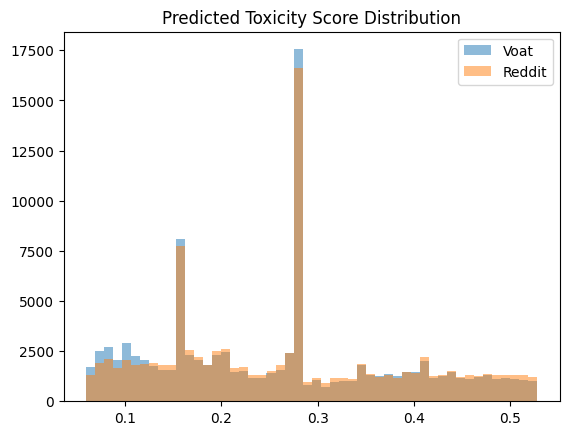

In [31]:
import matplotlib.pyplot as plt


plt.hist(
    model.predict_proba(voat[["sentiment_vader","sentiment_bert"]])[:,1],
    bins=50, alpha=0.5, label="Voat"
)
plt.hist(
    model.predict_proba(reddit[["sentiment_vader","sentiment_bert"]])[:,1],
    bins=50, alpha=0.5, label="Reddit"
)
plt.legend()
plt.title("Predicted Toxicity Score Distribution")
plt.show()


### Compare lexicon vs transformer

In [ ]:
# VADER only
model_vader = LogisticRegression(max_iter=1000)
model_vader.fit(X_train[["sentiment_vader"]], y_train)

# BERT only
model_bert = LogisticRegression(max_iter=1000)
model_bert.fit(X_train[["sentiment_bert"]], y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
for name, mdl, cols in [
    ("VADER", model_vader, ["sentiment_vader"]),
    ("BERT", model_bert, ["sentiment_bert"])
]:
    p = mdl.predict_proba(X_test[cols])[:,1]
    print(name, "AUC:", roc_auc_score(y_test, p))


VADER AUC: 0.6629574976157956
BERT AUC: 0.6415922683117852


In [35]:
def evaluate(train_df, test_df, name):
    results = {}
    for feat in ["sentiment_vader", "sentiment_bert"]:
        model = LogisticRegression(max_iter=1000)
        model.fit(train_df[[feat]], train_df["toxic"])
        p = model.predict_proba(test_df[[feat]])[:,1]
        results[feat] = roc_auc_score(test_df["toxic"], p)
    return results

print("Reddit → Reddit", evaluate(reddit, reddit, "RR"))
print("Reddit → Voat", evaluate(reddit, voat, "RV"))
print("Voat → Voat", evaluate(voat, voat, "VV"))
print("Voat → Reddit", evaluate(voat, reddit, "VR"))


Reddit → Reddit {'sentiment_vader': 0.6325781261953525, 'sentiment_bert': 0.6297127473334516}
Reddit → Voat {'sentiment_vader': 0.6629574976157956, 'sentiment_bert': 0.6415922683117852}
Voat → Voat {'sentiment_vader': 0.6629574976157956, 'sentiment_bert': 0.6415922683117852}
Voat → Reddit {'sentiment_vader': 0.6325781261953525, 'sentiment_bert': 0.6297127473334516}


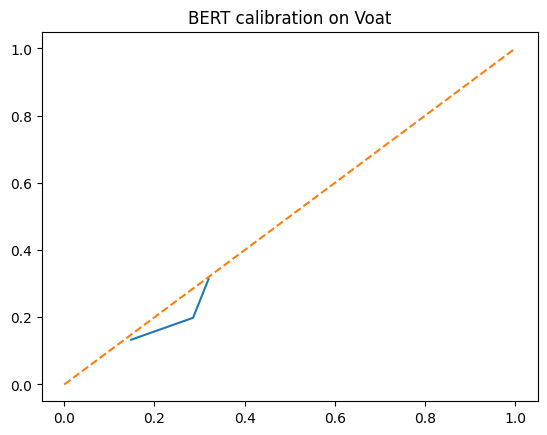

In [36]:
from sklearn.calibration import calibration_curve

p = model_bert.predict_proba(X_test[["sentiment_bert"]])[:,1]
prob_true, prob_pred = calibration_curve(y_test, p, n_bins=10)

plt.plot(prob_pred, prob_true)
plt.plot([0,1],[0,1],"--")
plt.title("BERT calibration on Voat")
plt.show()
